In [586]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from scipy import optimize as opt
from matplotlib import pyplot as plt

In [587]:
start = datetime.datetime(1970, 10, 1)
end = datetime.datetime(2018, 7, 1)

In [588]:
rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
gdp_def = web.DataReader('GDPDEF', 'fred', start, end)
tbill = web.DataReader('TB3MS', 'fred', start, end)

In [589]:
tbill = tbill.fillna(method="ffill")
w5000 = w5000.fillna(method="ffill")
tbill = tbill.resample('QS').first()
w5000 = w5000.resample('QS').first()

In [590]:
df = pd.DataFrame(columns=['rpce', 'w5000', 'tbill', 'gdp_def'], index = rpce.index)
df['rpce'] = rpce
df['w5000'] = w5000
df['tbill'] = tbill / 100 + 1
df['gdp_def'] = (gdp_def / 100)
df['gdp_def'] /= df['gdp_def'][0]
df['w5000_real'] = df['w5000'] / (df['gdp_def'])
df['R'] = df['w5000_real'] / df['w5000_real'].shift(1)

df.dropna(axis=0, inplace=True)

In [591]:
df.head()

,rpce,w5000,tbill,gdp_def,w5000_real,R
DATE,,,,,,
1971-01-01,2968.902,1.00,1.0444,1.015270,0.984959,0.984959
1971-04-01,2996.124,1.12,1.0386,1.028643,1.088813,1.105440
1971-07-01,3020.036,1.13,1.0540,1.039082,1.087498,0.998792
1971-10-01,3070.230,1.12,1.0446,1.047709,1.068999,0.982989
1972-01-01,3110.801,1.18,1.0338,1.063929,1.109097,1.037510


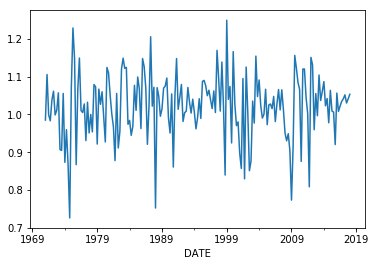

In [592]:
df['R'].plot()
plt.show()

### Exercise 2.5.1

In [596]:
def sdf(γ, df, β):
    mu_c = df['rpce'] ** (-γ)
    return β * (mu_c.shift(-1) / mu_c)

def cov(m, R):
    return m.cov(R)

def objective_1(γ, *args):
    df, β = args
    Rt1 = df['R']
    mt1 = sdf(γ, df, β)
    return 1 - cov(mt1, Rt1) - mt1.mean() * Rt1.mean()

In [597]:
β = 0.99
result_1 = opt.root(objective_1, 1.0, args=(df, β))
opt_γ_1 = result_1.x[0]
print(f'γ = {opt_γ_1}')

γ = 1.3976560035249992


### Exercise 2.5.2

### Exercise 2.5.3

In [614]:
def objective_3(γ, *args):
    df, β = args
    rf = df['tbill']
    E_mt1 = sdf(γ, df, β).mean()
    errors = rf - (1 / E_mt1)
    return np.sum(errors ** 2)

In [615]:
β = 0.99
result_3 = opt.minimize(objective_3, 1.0, args=(df, β))
opt_γ_3 = result_3.x[0]
print(f'γ = {opt_γ_3}')

γ = 4.875939898352705


### Exercise 2.5.4

In [658]:
def errors(β, γ, df):
    Rt1 = df['R']
    mt1 = sdf(γ, df, β)
    error_1 = 1 - cov(mt1, Rt1) - mt1.mean() * Rt1.mean()
    rf = df['tbill']
    E_mt1 = mt1.mean()
    error_2 = np.sum((rf - (1 / E_mt1)) ** 2)
    return np.array([error_1, error_2])

def objective_4(params, df):
    β, γ = params
    return np.sum(errors(β, γ, df) ** 2)


In [659]:
guess = np.array([1.0, 3.0])
result_4 = opt.minimize(objective_4, guess, args=df)
opt_β_4, opt_γ_4 = result_4.x
print(f'γ = {opt_γ_4}\nβ = {opt_β_4}')

γ = 3.00061893038935
β = 0.9768151685598975


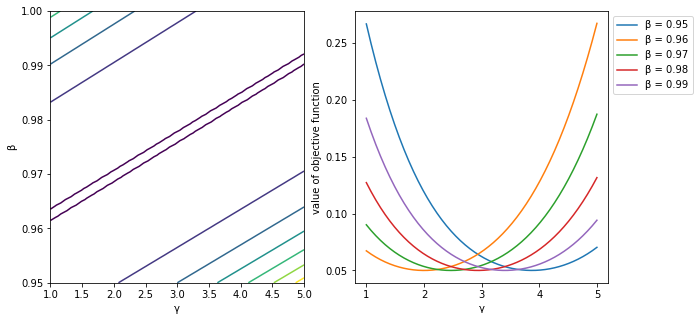

In [689]:
β_grid = np.linspace(0.95, 1, 50)
γ_grid = np.linspace(1, 5, 50)

Β, Γ = np.meshgrid(β_grid, γ_grid)
obj = np.empty_like(Β)
for i, γ in enumerate(γ_grid):
    for j, β in enumerate(β_grid):
        obj[i, j] = objective_4([β, γ], df)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].contour(Γ, Β, obj)
axes[0].set_xlabel("γ")
axes[0].set_ylabel("β")
for i, β in enumerate(β_grid[::10]):
    axes[1].plot(γ_grid, obj[10 * (i - 1)], label=f"β = {round(β, 2)}")
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1))
axes[1].set_xlabel("γ")
axes[1].set_ylabel("value of objective function")
plt.show()